In [46]:
%load_ext autoreload
%autoreload 3
import numpy as np
import pandas as pd
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
from utils.constants import xai_names, selected_uni
from utils.visualization import plot_multiple_images_with_attribution
from utils.shapelet import get_distances_info_gain
from utils.insert_shapelet import get_gt_attr
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [3]:
from tsai.models.FCN import FCN
model_path = 'models/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)

test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)
preds = np.load(f'{model_path}/test_preds.npy')

DeepLift


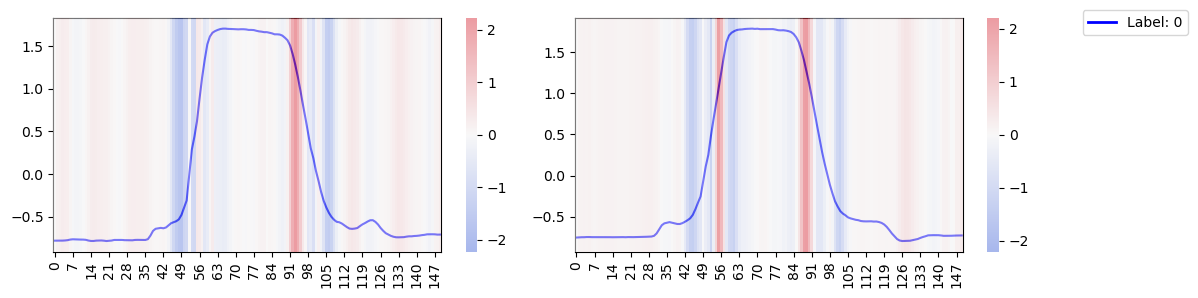

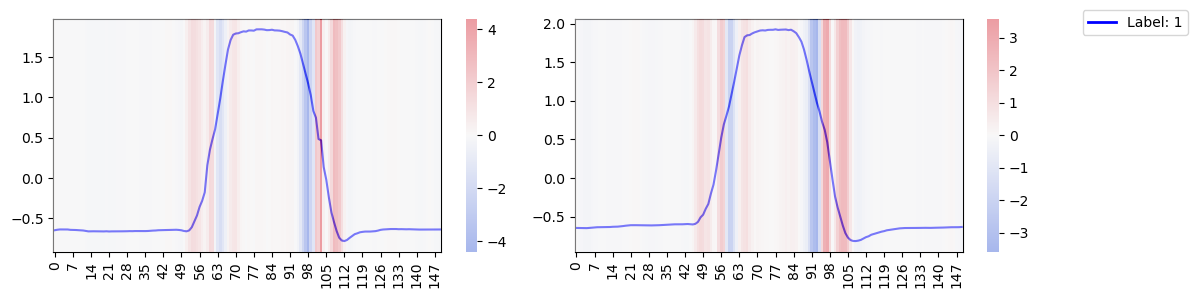

In [66]:
for xai_name in ['DeepLift']:
    print(xai_name)
    attr_gp, _= get_gt_attr(model,train_x,None,None,
                            save_dir=f'attributions/GunPoint/{xai_name}',
                            xai_name=xai_name,target_class=None)


    # with open(f'attributions/GunPoint/{xai_name}/train_exp.pkl', 'rb') as f:
    #     attr = pickle.load(f)
    # attr_gp = attr['attributions']
    plot_multiple_images_with_attribution(train_x[np.where(train_y==0)], train_y[np.where(train_y==0)], 2, (1, 2), (12, 3), 
                                          use_attribution=True,
                                          attributions=attr_gp[np.where(train_y==0)],
                                          normalize_attribution=True,
                                          save_path=None,
                                          test_y = train_y[np.where(train_y==0)],
                                         )
    plot_multiple_images_with_attribution(train_x[np.where(train_y==1)], train_y[np.where(train_y==1)], 2, (1, 2), (12, 3), 
                                          use_attribution=True,
                                          attributions=attr_gp[np.where(train_y==1)],
                                          normalize_attribution=True,
                                          save_path=None,
                                          test_y = train_y[np.where(train_y==1)],
                                         )

In [67]:
with open('attributions/GunPoint/DeepLift/train_exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

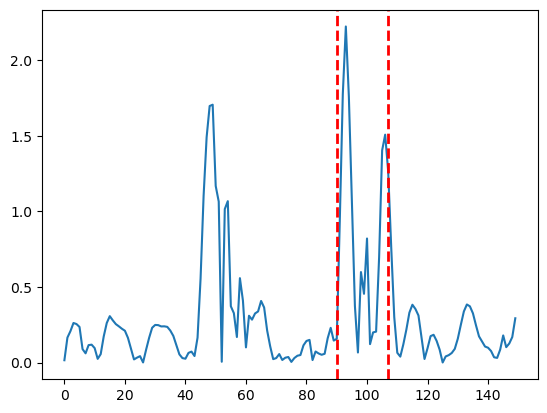

In [68]:
plt.plot(np.abs(attr_gp[2]))
plt.axvline(x=90, color='r', linestyle='--', linewidth=2)
plt.axvline(x=107, color='r', linestyle='--', linewidth=2)

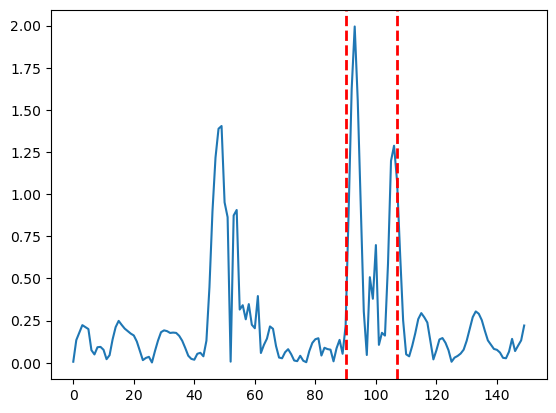

In [10]:
plt.plot(np.abs(attr_gp[2]))
plt.axvline(x=90, color='r', linestyle='--', linewidth=2)
plt.axvline(x=107, color='r', linestyle='--', linewidth=2)

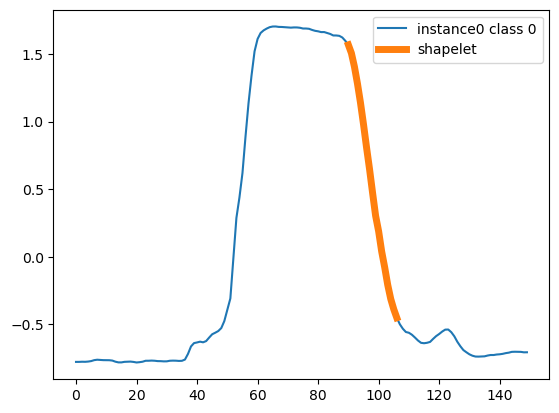

In [179]:
plt.plot(train_x[2].flatten(),label=f'instance{0} class {test_y[0]}')
plt.plot(np.arange(90,107),train_x[2,:,90:107].flatten(),
         linewidth=5,label='shapelet')
plt.legend()
# plt.plot(test_x[0,:,30:55].flatten())

In [72]:
shapelet = train_x[2,:,90:107].flatten()
length = len(shapelet)
shapelet_distances_train, info_gain, best_threshold = get_distances_info_gain(dataset=train_x, shapelet=shapelet, length=length, pos=42, labels=train_y)
print(info_gain,length)

0.2733514385139578 17


In [181]:
shapelet_distances_test, info_gain, best_threshold = get_distances_info_gain(dataset=test_x, shapelet=shapelet, length=length, pos=30, labels=test_y)
print(info_gain)

0.46582818999330866


In [182]:
from sklearn.metrics import (
    accuracy_score,
)
from sklearn.linear_model import LinearRegression

In [183]:
shapelet_distances_train = shapelet_distances_train.reshape(-1, 1)
shapelet_distances_test = shapelet_distances_test.reshape(-1, 1)

classifier = LinearRegression()
classifier.fit(shapelet_distances_train, train_y)
train_pred = classifier.predict(shapelet_distances_train)
train_pred[train_pred < 0.5] = 0
train_pred[train_pred >= 0.5] = 1

test_pred = classifier.predict(shapelet_distances_test)
test_pred[test_pred < 0.5] = 0
test_pred[test_pred >= 0.5] = 1

print(f'Training Accuracy = {accuracy_score(train_y, train_pred):.2f}')
print(f'Testing Accuracy = {accuracy_score(test_y, test_pred):.2f}')



Training Accuracy = 0.80
Testing Accuracy = 0.85


In [48]:
from utils.insert_shapelet import insert_data_to_env,get_bg_pred
from utils.constants import selected_uni
import pandas as pd
from utils.visualization import plot_multiple_images_with_attribution

In [49]:
bg_per = get_bg_pred(model=model, selected_datasets=selected_datasets, 
            inst_length=inst_length, target_class=0, device='cuda')

In [53]:
shapelet = train_x[2,:,90:107].flatten()
selected_datasets = selected_uni
inst_length = 150
DF = pd.DataFrame({})
DF.index = selected_uni
DF['bg'] = bg_per.values()
for i in range(4):
    save_dir = f'probe/insert_implet_datasets/{i}'
    dataset_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                                 selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                                 is_add=False,
                                                                    xai_name=None, num_attribution_each=None,
                                                                    target_class=0, repeat_max=100,
                                                                    is_z_norm=True, is_plot=False, is_verbose=False,
                                                                    img_path=None,
                                                                    save_dir=save_dir, device='cuda')
    
    DF[f'insert_num_{i}'] = insert_shapelet_percentage.values()
DF

,bg,insert_num_0,insert_num_1,insert_num_2,insert_num_3
ECG200,0.00,0.00,0.00,0.0,0.0
Beef,0.00,0.00,0.00,0.0,0.0
ElectricDevices,0.00,0.00,0.00,0.0,0.0
Earthquakes,0.00,0.00,0.00,0.0,0.0
Wafer,0.00,0.00,0.00,0.0,0.0
PowerCons,0.00,0.00,0.00,0.0,0.0
NonInvasiveFetalECGThorax1,0.00,0.00,0.00,0.0,0.0
ECG5000,0.00,0.00,0.00,0.0,0.0
GunPoint,0.48,0.48,0.08,0.0,0.0
HandOutlines,0.00,0.00,0.00,0.0,0.0


In [54]:
for i in range(4):
    save_dir = f'probe/insert_implet_datasets/{i}'
    deeplift_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                                 selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                                 is_add=False,
                                                                 xai_name='DeepLift', num_attribution_each=None,
                                                                 target_class=0, repeat_max=100,
                                                                 is_z_norm=True, is_plot=False, is_verbose=False,
                                                                 img_path=None,
                                                                 save_dir=save_dir, device='cuda')

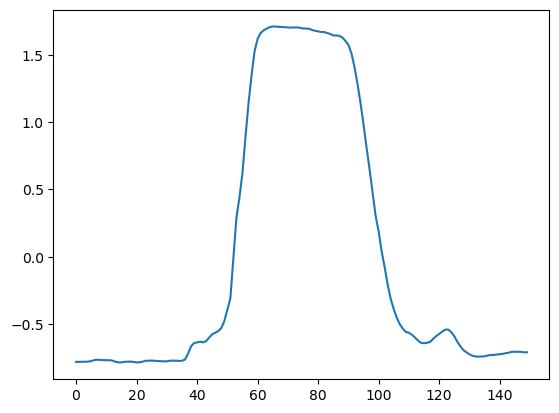

In [63]:
plt.plot(inst[0].flatten())

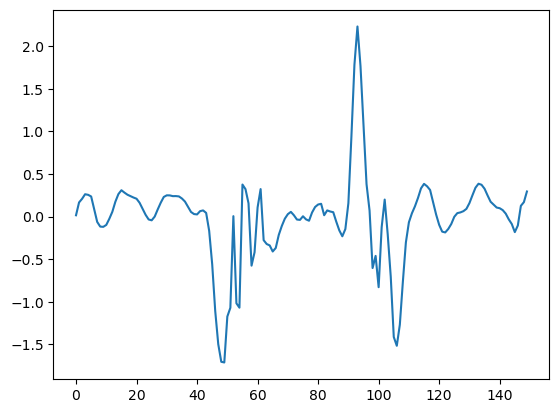

In [60]:
plt.plot(attr[0])

[-2.7358494 -0.6837456]


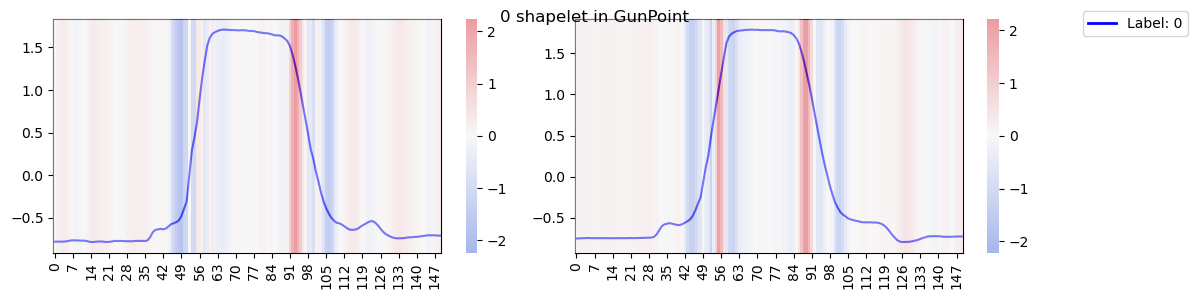

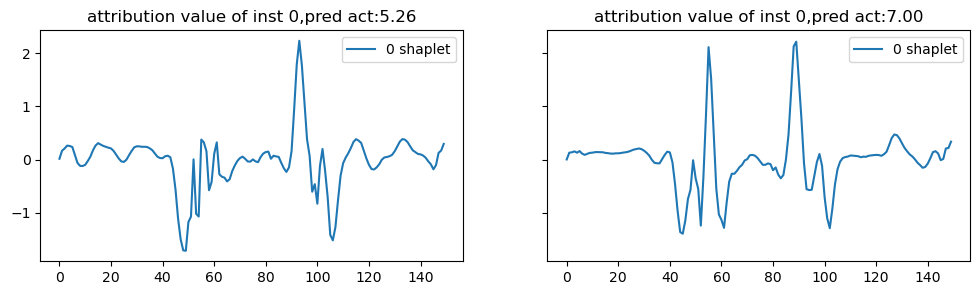

[-36.42119   25.844976]


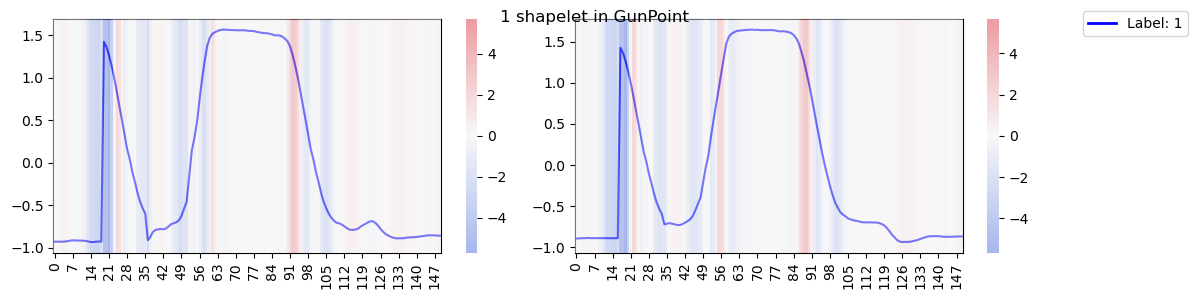

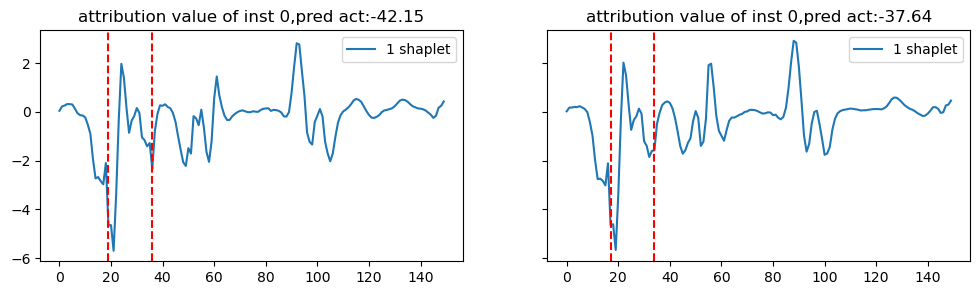

[-66.679924  49.567818]


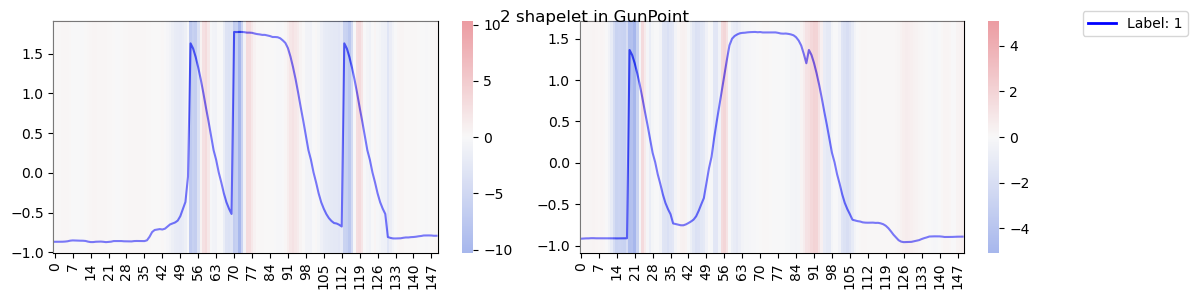

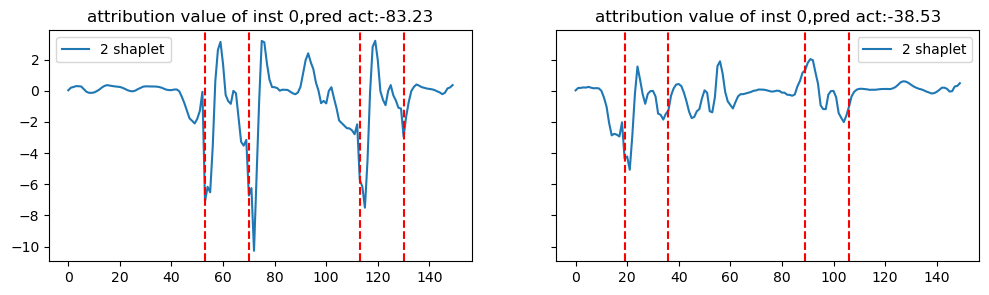

[-116.60227   89.126  ]


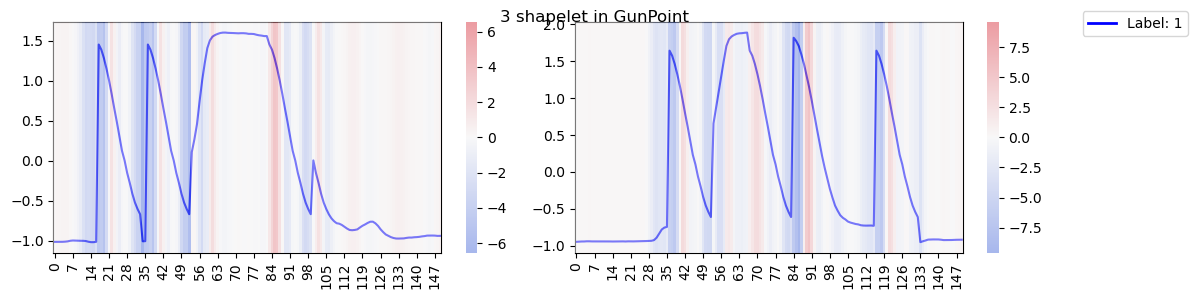

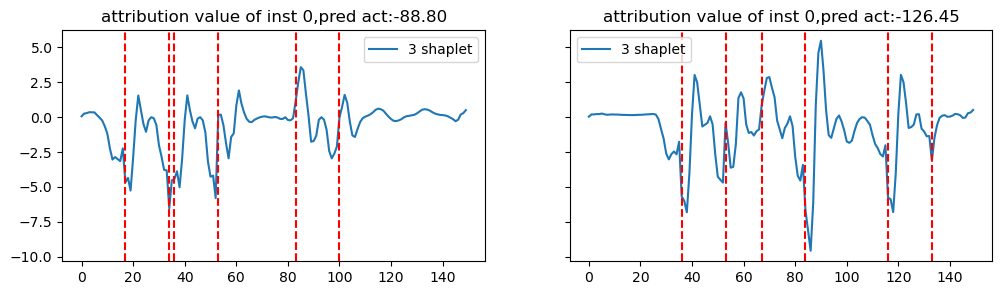

In [80]:
for i in range(4):
    path = f'probe/insert_implet_datasets/{i}/'
    dataset = 'GunPoint'
    with open(path + f'DeepLift/{dataset}.pkl', 'rb') as f:
        ECG_attr = pickle.load(f)
        attr = ECG_attr['attributions']
    with open(path + f'{dataset}.pkl', 'rb') as f:
        ECG_inst = pickle.load(f)
        inst = ECG_inst['train_x']
        preds = ECG_inst['preds']
        startings = ECG_inst['startings']
        length = ECG_inst['length']
        print(np.mean(preds,axis=0))

    inst = inst[np.where(train_y==0)]
    preds = preds[np.where(train_y==0)]
    attr = attr[np.where(train_y==0)]
    startings = [startings[j] for j in range(len(startings)) if j in np.where(train_y==0)[0]]
    plot_multiple_images_with_attribution(inst, preds, 2, figsize=(12, 3), use_attribution=True,
                                              attributions=attr, normalize_attribution=True, title=f"{i} shapelet in {dataset}", save_path=None,
                                              test_y=None)
    fig,axs = plt.subplots(1,2,figsize=(12,3),sharey=True)
    for j in range(2):
        axs[j].plot(attr[j],label=f'{i} shaplet')
        
        axs[j].set_title(f'attribution value of inst 0,pred act:{np.array(preds[j][0]):.2f}')
        for starting in startings[j]:
           
            axs[j].axvline(starting,color='r',linestyle='--')
            axs[j].axvline(starting+length,color='r',linestyle='--')
        axs[j].legend()
    plt.show()

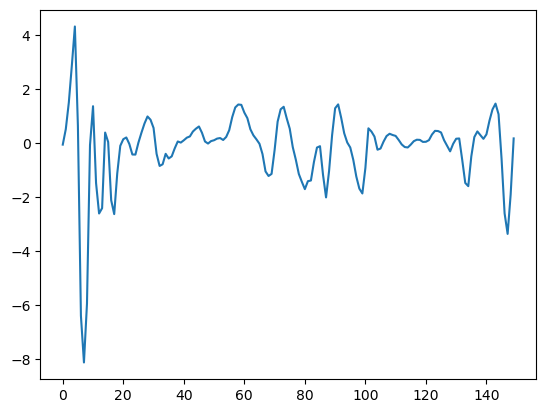

In [72]:
with open('probe/insert_shapelet_datasets/1/DeepLift/ECG200.pkl', 'rb') as f:
    ECG_1_shape = pickle.load(f)
    attr = ECG_1_shape['attributions']
plt.plot(attr[0])

## Now we have only the positive attribution parts

In [99]:
with open('attributions/GunPoint/DeepLift/train_exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

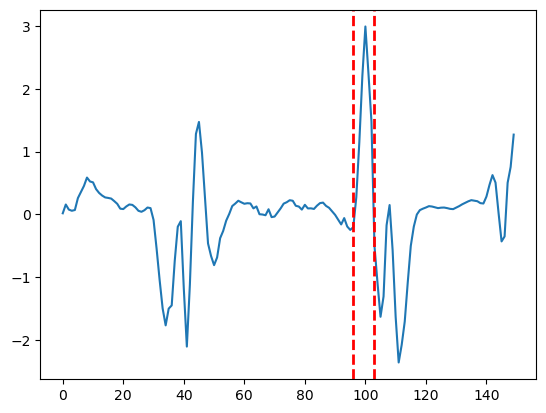

In [110]:
plt.plot(attr_gp[0])
plt.axvline(x=96, color='r', linestyle='--', linewidth=2)
plt.axvline(x=103, color='r', linestyle='--', linewidth=2)

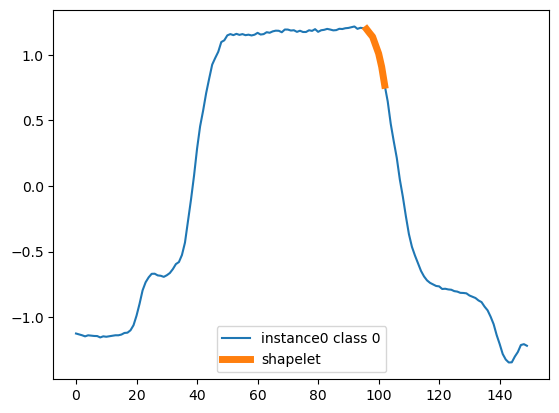

In [111]:
plt.plot(test_x[0].flatten(),label=f'instance{0} class {test_y[0]}')
plt.plot(np.arange(96,103),test_x[0,:,96:103].flatten(),
         linewidth=5,label='shapelet')
plt.legend()
# plt.plot(test_x[0,:,30:55].flatten())

In [143]:
shapelet = test_x[0,:,96:103].flatten()
length = len(shapelet)
shapelet_distances_train, info_gain, best_threshold = get_distances_info_gain(dataset=train_x, shapelet=shapelet, length=length, pos=96, labels=train_y)


In [134]:
from utils.shapelet import compute_shapelet_distance

In [139]:
compute_shapelet_distance(test_x[0], shapelet, length=length, position=96)


0.0 96


In [140]:
shapelet_distances_test, info_gain, best_threshold = get_distances_info_gain(dataset=test_x, shapelet=shapelet, length=length, pos=96, labels=test_y)
print(info_gain)

0.06566781650220332


In [141]:
from sklearn.metrics import (
    accuracy_score,
)
from sklearn.linear_model import LinearRegression

In [146]:
shapelet_distances_train = shapelet_distances_train.reshape(-1, 1)
shapelet_distances_test = shapelet_distances_test.reshape(-1, 1)

classifier = LinearRegression()
classifier.fit(shapelet_distances_train, train_y)
train_pred = classifier.predict(shapelet_distances_train)
train_pred[train_pred < 0.5] = 0
train_pred[train_pred >= 0.5] = 1

test_pred = classifier.predict(shapelet_distances_test)
test_pred[test_pred < 0.5] = 0
test_pred[test_pred >= 0.5] = 1

print(f'Training Accuracy = {accuracy_score(train_y, train_pred):.2f}')
print(f'Testing Accuracy = {accuracy_score(test_y, test_pred):.2f}')

Training Accuracy = 0.50
Testing Accuracy = 0.55


In [59]:
from utils.insert_shapelet import insert_data_to_env,get_bg_pred
from utils.constants import selected_uni
import pandas as pd
from utils.visualization import plot_multiple_images_with_attribution
from utils import *

In [63]:
inst_length = 150
bg_per = get_bg_pred(model=model, selected_datasets=selected_uni, 
            inst_length=inst_length, target_class=0, device='cuda')

In [64]:
bg_per

{'ECG200': 0.0,
 'Beef': 0.0,
 'ElectricDevices': 0.0,
 'Earthquakes': 0.0,
 'Wafer': 0.0,
 'PowerCons': 0.0,
 'NonInvasiveFetalECGThorax1': 0.0,
 'ECG5000': 0.0,
 'GunPoint': 0.48,
 'HandOutlines': 0.0,
 'CBF': 0.0,
 'FordA': 0.0,
 'TwoPatterns': 0.0,
 'UWaveGestureLibraryAll': 0.0,
 'Chinatown': 1.0,
 'Yoga': 0.0,
 'DistalPhalanxOutlineCorrect': 0.0,
 'Computers': 0.0,
 'ShapesAll': 0.0,
 'Strawberry': 0.0}

In [65]:
shapelet = test_x[0,:,96:103].flatten()
selected_datasets = selected_uni
inst_length = 150
DF = pd.DataFrame({})
DF.index = selected_uni
DF['bg'] = bg_per.values()
for i in range(1,4):
    save_dir = f'probe/insert_shapelet_2/{i}'
    dataset_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                                 selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                                 is_add=False,
                                                                    xai_name=None, num_attribution_each=None,
                                                                    target_class=0, repeat_max=100,
                                                                    is_z_norm=True, is_plot=False, is_verbose=False,
                                                                    img_path=None,
                                                                    save_dir=save_dir, device='cuda')
    
    DF[f'insert_num_{i}'] = insert_shapelet_percentage.values()
DF

,bg,insert_num_1,insert_num_2,insert_num_3
ECG200,0.00,0.00,0.00,0.00
Beef,0.00,0.00,0.00,0.00
ElectricDevices,0.00,0.00,0.00,0.00
Earthquakes,0.00,0.00,0.00,0.00
Wafer,0.00,0.00,0.00,0.00
PowerCons,0.00,0.00,0.00,0.00
NonInvasiveFetalECGThorax1,0.00,0.00,0.00,0.00
ECG5000,0.00,0.00,0.00,0.00
GunPoint,0.48,0.16,0.06,0.02
HandOutlines,0.00,0.00,0.00,0.00


In [122]:
for i in range(4):
    shapelet = test_x[0,:,96:103].flatten()
    save_dir = f'probe/insert_shapelet_2/{i}'
    deeplift_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                                 selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                                 is_add=False,
                                                                 xai_name='DeepLift', num_attribution_each=None,
                                                                 target_class=0, repeat_max=100,
                                                                 is_z_norm=True, is_plot=False, is_verbose=False,
                                                                 img_path=None,
                                                                 save_dir=save_dir, device='cuda')

[[ -21.557827   13.57855 ]
 [-123.12366    95.04367 ]]


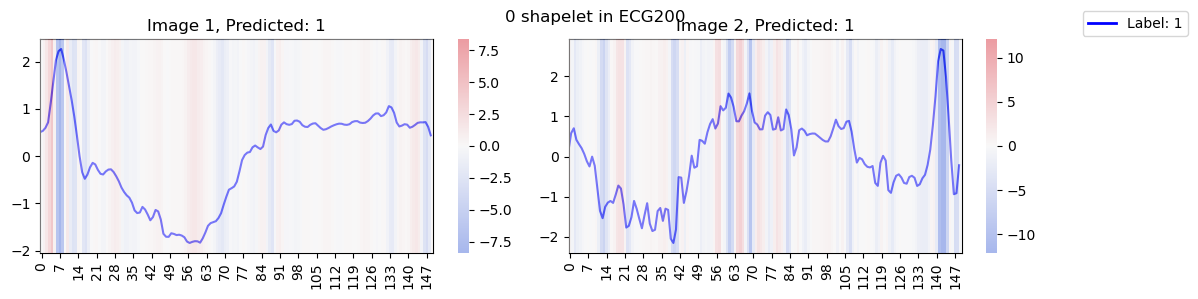

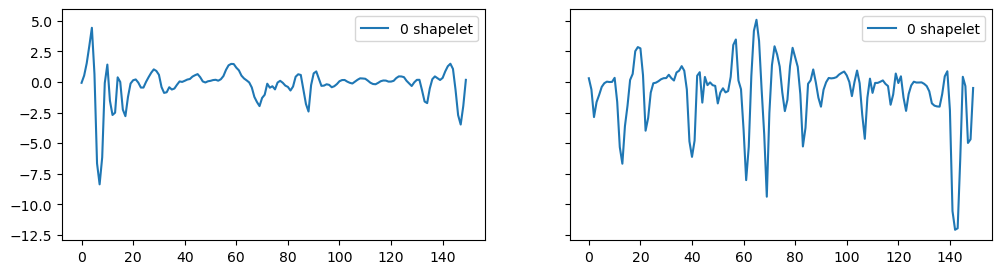

[[ -55.857582   41.435463]
 [-118.98994    91.73128 ]]


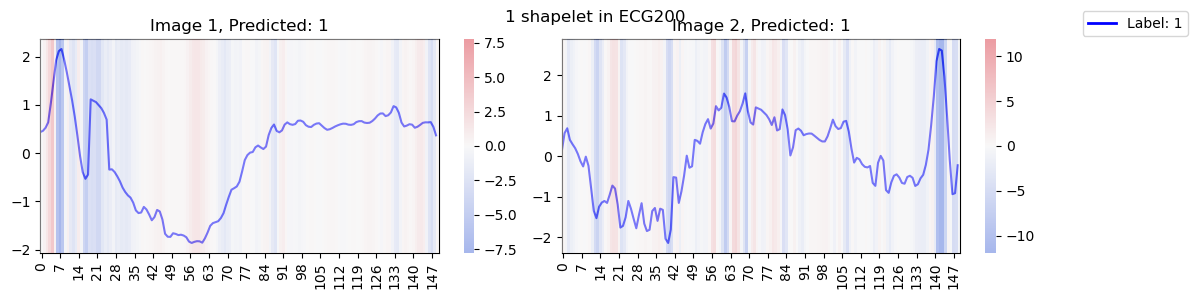

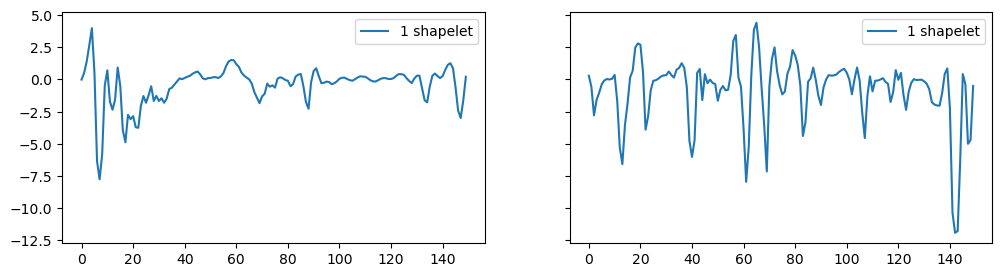

[[-218.52754  173.56636]
 [-256.20377  203.52669]]


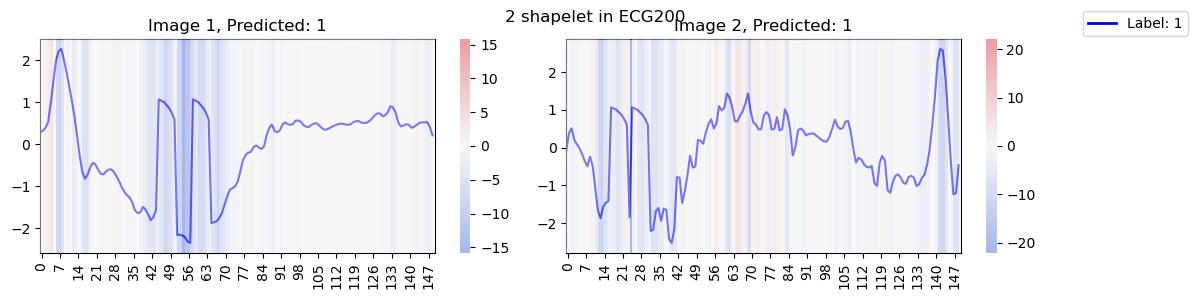

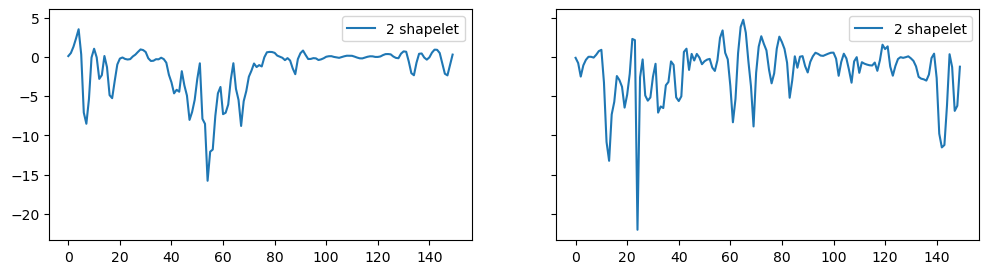

[[ -62.528698   46.191998]
 [-240.84044   191.04712 ]]


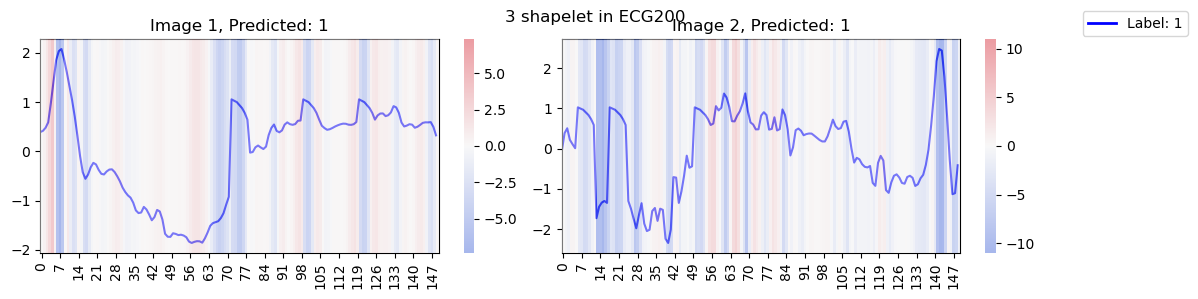

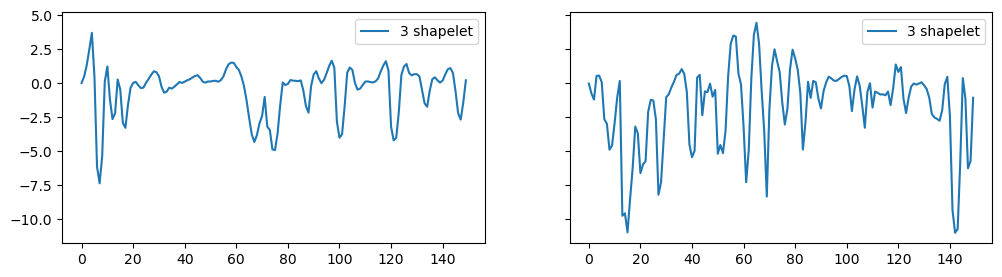

In [10]:
for i in range(4):
    path = f'probe/insert_shapelet_2/{i}/'
    with open(path + 'DeepLift/ECG200.pkl', 'rb') as f:
        ECG_attr = pickle.load(f)
        attr = ECG_attr['attributions']
    with open(path + 'ECG200.pkl', 'rb') as f:
        ECG_inst = pickle.load(f)
        inst = ECG_inst['train_x']
        preds = ECG_inst['preds']
        print(preds[0:2])
    plot_multiple_images_with_attribution(inst, preds, 2, (1,2), figsize=(12, 3), use_attribution=True,
                                              attributions=attr, normalize_attribution=True, title=f"{i} shapelet in ECG200", save_path=None,
                                              test_y=None)
    fig,axs = plt.subplots(1,2,figsize=(12,3),sharey=True)
    axs[0].plot(attr[0],label=f'{i} shapelet')
    axs[0].legend()
    axs[1].plot(attr[1],label=f'{i} shapelet')
    axs[1].legend()
    plt.show()

In [80]:
len(inst[0].flatten())

array([ 5.08089270e-01,  5.33862159e-01,  5.98493171e-01,  7.14303174e-01,
        1.12202315e+00,  1.57623535e+00,  2.03095916e+00,  2.22291467e+00,
        2.26618893e+00,  2.04457187e+00,  1.77654911e+00,  1.47630737e+00,
        1.18068227e+00,  8.36041813e-01,  4.32126977e-01,  6.55263958e-04,
       -3.41096578e-01, -4.80636650e-01, -3.91845577e-01, -2.38503042e-01,
       -1.43114035e-01, -1.76825760e-01, -2.91530057e-01, -3.75185376e-01,
       -3.89126821e-01, -3.25608405e-01, -2.85394639e-01, -2.79820203e-01,
       -3.37640442e-01, -4.27631089e-01, -5.33777932e-01, -6.65768790e-01,
       -7.60271671e-01, -8.31394722e-01, -8.80092096e-01, -9.85527194e-01,
       -1.14890720e+00, -1.20611391e+00, -1.19470666e+00, -1.07535029e+00,
       -1.13034826e+00, -1.23641802e+00, -1.35861732e+00, -1.29115125e+00,
       -1.13960934e+00, -1.17158405e+00, -1.34264930e+00, -1.64428934e+00,
       -1.70722597e+00, -1.70929266e+00, -1.63333406e+00, -1.64729242e+00,
       -1.67191487e+00, -